In [2]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
import os
import cv2

c:\Users\pc\miniconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\pc\miniconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\pc\miniconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

# Loading Augmented Images to Tensorflow Dataset.

In [4]:
def loader_images(path):
    images = tf.data.Dataset.list_files(path, shuffle=False)
    images = images.map(load_image)
    images = images.map(lambda x: tf.image.resize(x, (120,120)))
    images = images.map(lambda x: x/255)
    return images

In [5]:
train_images = loader_images('aug_data\\train\\images\\*.jpg')
test_images = loader_images('aug_data\\test\\images\\*.jpg')
val_images = loader_images('aug_data\\val\\images\\*.jpg')

# Loading Augmented Labels to tensorflow Dataset.

In [6]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
    return [label['class']], label['bbox']

In [7]:
def loader_labels(path):
    labels = tf.data.Dataset.list_files(path, shuffle=False)
    labels = labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
    return labels

In [8]:
train_labels = loader_labels('aug_data\\train\\labels\\*.json')
test_labels = loader_labels('aug_data\\test\\labels\\*.json')
val_labels = loader_labels('aug_data\\val\\labels\\*.json')

# Zipping images and labels pairs

In [9]:
def zipper(image,label):
    temp = tf.data.Dataset.zip((image, label))
    temp = temp.shuffle(5000)
    temp = temp.batch(8)
    temp = temp.prefetch(4)
    return temp

In [10]:
train = zipper(train_images,train_labels)
test = zipper(test_images,test_labels)
val = zipper(val_images,val_labels)

# Viewing some imput(images) and output(labels) Pairs.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


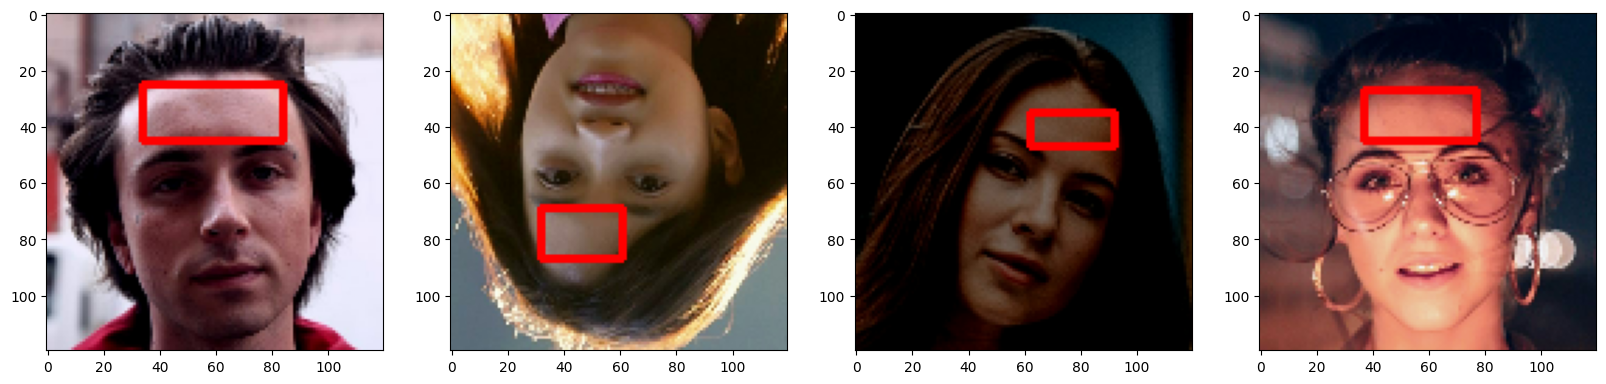

In [11]:
data_samples = train.as_numpy_iterator()
res = data_samples.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model

In [13]:
vgg = VGG16(include_top=False)  # we dont want all three dense layer as we wanted to bring down the prediction time. More number of dense layer will slow down the predcition time.

In [14]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    forehead = Model(inputs=input_layer, outputs=[class2, regress2])
    return forehead
forehead = build_model()

In [15]:
optimiz = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [16]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [17]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [18]:
class ForeheadTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        optimiz.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [19]:
model = ForeheadTracker(forehead)
model.compile(optimiz, classloss, regressloss)

# Training

In [36]:
hist = model.fit(train, epochs=30, validation_data=val)

# We have done the training on kaggle. So, that's why we are adding the Training History in the Below markdown cell.

######
Epoch 1/30 </br>
2910/2910 [==============================] - 212s 69ms/step - total_loss: 0.0255 - class_loss: 3.5175e-07 - regress_loss: 0.0255 - val_total_loss: 0.0089 - val_class_loss: 0.0000e+00 - val_regress_loss: 0.0089 </br>
Epoch 2/30</br>
2910/2910 [==============================] - 211s 68ms/step - total_loss: 0.0205 - class_loss: 4.3337e-08 - regress_loss: 0.0205 - val_total_loss: 5.9762e-04 - val_class_loss: 0.0000e+00 - val_regress_loss: 5.9762e-04 </br>
Epoch 3/30</br>
2910/2910 [==============================] - 212s 68ms/step - total_loss: 0.0155 - class_loss: 6.4447e-09 - regress_loss: 0.0155 - val_total_loss: 0.0035 - val_class_loss: 0.0000e+00 - val_regress_loss: 0.0035</br>
Epoch 4/30</br>
2910/2910 [==============================] - 209s 68ms/step - total_loss: 0.0126 - class_loss: 1.5459e-09 - regress_loss: 0.0126 - val_total_loss: 0.0063 - val_class_loss: 0.0000e+00 - val_regress_loss: 0.0063</br>
Epoch 5/30</br>
2910/2910 [==============================] - 209s 67ms/step - total_loss: 0.0098 - class_loss: 1.0340e-09 - regress_loss: 0.0098 - val_total_loss: 7.9867e-04 - val_class_loss: 0.0000e+00 - val_regress_loss: 7.9867e-04</br>
Epoch 6/30</br>
2910/2910 [==============================] - 210s 68ms/step - total_loss: 0.0087 - class_loss: 1.4845e-10 - regress_loss: 0.0087 - val_total_loss: 2.1175e-04 - val_class_loss: 0.0000e+00 - val_regress_loss: 2.1175e-04</br>
Epoch 7/30</br>
2910/2910 [==============================] - 210s 68ms/step - total_loss: 0.0075 - class_loss: 1.4333e-10 - regress_loss: 0.0075 - val_total_loss: 0.0011 - val_class_loss: 0.0000e+00 - val_regress_loss: 0.0011</br>
Epoch 8/30</br>
2910/2910 [==============================] - 210s 68ms/step - total_loss: 0.0066 - class_loss: 4.6070e-11 - regress_loss: 0.0066 - val_total_loss: 2.1995e-04 - val_class_loss: 0.0000e+00 - val_regress_loss: 2.1995e-04</br>
Epoch 9/30</br>
2910/2910 [==============================] - 210s 68ms/step - total_loss: 0.0062 - class_loss: 3.0713e-11 - regress_loss: 0.0062 - val_total_loss: 0.0023 - val_class_loss: 0.0000e+00 - val_regress_loss: 0.0023</br>
Epoch 10/30</br>
2910/2910 [==============================] - 210s 68ms/step - total_loss: 0.0057 - class_loss: 5.1189e-12 - regress_loss: 0.0057 - val_total_loss: 0.0023 - val_class_loss: 0.0000e+00 - val_regress_loss: 0.0023</br>
Epoch 11/30</br>
2910/2910 [==============================] - 208s 67ms/step - total_loss: 0.0053 - class_loss: 5.1189e-12 - regress_loss: 0.0053 - val_total_loss: 0.0019 - val_class_loss: 0.0000e+00 - val_regress_loss: 0.0019</br>
Epoch 12/30</br>
2910/2910 [==============================] - 209s 67ms/step - total_loss: 0.0051 - class_loss: 1.5357e-11 - regress_loss: 0.0051 - val_total_loss: 0.0032 - val_class_loss: 0.0000e+00 - val_regress_loss: 0.0032</br>
Epoch 13/30</br>
2910/2910 [==============================] - 207s 67ms/step - total_loss: 0.0047 - class_loss: 0.0000e+00 - regress_loss: 0.0047 - val_total_loss: 8.6391e-04 - val_class_loss: 0.0000e+00 - val_regress_loss: 8.6391e-04</br>
Epoch 14/30</br>
2910/2910 [==============================] - 207s 67ms/step - total_loss: 0.0046 - class_loss: 2.5595e-11 - regress_loss: 0.0046 - val_total_loss: 7.0360e-04 - val_class_loss: 0.0000e+00 - val_regress_loss: 7.0360e-04</br>
Epoch 15/30</br>
2910/2910 [==============================] - 209s 67ms/step - total_loss: 0.0041 - class_loss: 0.0000e+00 - regress_loss: 0.0041 - val_total_loss: 5.3320e-04 - val_class_loss: 0.0000e+00 - val_regress_loss: 5.3320e-04</br>
Epoch 16/30</br>
2910/2910 [==============================] - 209s 67ms/step - total_loss: 0.0041 - class_loss: 0.0000e+00 - regress_loss: 0.0041 - val_total_loss: 0.0101 - val_class_loss: 0.0000e+00 - val_regress_loss: 0.0101</br>
Epoch 17/30</br>
2910/2910 [==============================] - 206s 67ms/step - total_loss: 0.0039 - class_loss: 0.0000e+00 - regress_loss: 0.0039 - val_total_loss: 0.0139 - val_class_loss: 0.0000e+00 - val_regress_loss: 0.0139</br>
Epoch 18/30</br>
2910/2910 [==============================] - 208s 67ms/step - total_loss: 0.0039 - class_loss: 0.0000e+00 - regress_loss: 0.0039 - val_total_loss: 0.0039 - val_class_loss: 0.0000e+00 - val_regress_loss: 0.0039</br>
Epoch 19/30</br>
2910/2910 [==============================] - 207s 67ms/step - total_loss: 0.0036 - class_loss: 0.0000e+00 - regress_loss: 0.0036 - val_total_loss: 0.0049 - val_class_loss: 0.0000e+00 - val_regress_loss: 0.0049</br>
Epoch 20/30</br>
2910/2910 [==============================] - 208s 67ms/step - total_loss: 0.0035 - class_loss: 0.0000e+00 - regress_loss: 0.0035 - val_total_loss: 3.4516e-04 - val_class_loss: 0.0000e+00 - val_regress_loss: 3.4516e-04
Epoch 21/30</br>
2910/2910 [==============================] - 209s 67ms/step - total_loss: 0.0035 - class_loss: 0.0000e+00 - regress_loss: 0.0035 - val_total_loss: 0.0062 - val_class_loss: 0.0000e+00 - val_regress_loss: 0.0062</br>
Epoch 22/30</br>
2910/2910 [==============================] - 210s 67ms/step - total_loss: 0.0033 - class_loss: 0.0000e+00 - regress_loss: 0.0033 - val_total_loss: 0.0058 - val_class_loss: 0.0000e+00 - val_regress_loss: 0.0058</br>
Epoch 23/30</br>
2910/2910 [==============================] - 209s 68ms/step - total_loss: 0.0033 - class_loss: 0.0000e+00 - regress_loss: 0.0033 - val_total_loss: 0.0034 - val_class_loss: 0.0000e+00 - val_regress_loss: 0.0034</br>
Epoch 24/30</br>
2910/2910 [==============================] - 209s 68ms/step - total_loss: 0.0031 - class_loss: 0.0000e+00 - regress_loss: 0.0031 - val_total_loss: 8.5033e-04 - val_class_loss: 0.0000e+00 - val_regress_loss: 8.5033e-04</br>
Epoch 25/30</br>
2910/2910 [==============================] - 207s 67ms/step - total_loss: 0.0030 - class_loss: 0.0000e+00 - regress_loss: 0.0030 - val_total_loss: 0.0131 - val_class_loss: 0.0000e+00 - val_regress_loss: 0.0131</br>
Epoch 26/30</br>
2910/2910 [==============================] - 206s 67ms/step - total_loss: 0.0030 - class_loss: 0.0000e+00 - regress_loss: 0.0030 - val_total_loss: 2.0683e-04 - val_class_loss: 0.0000e+00 - val_regress_loss: 2.0683e-04</br>
Epoch 27/30</br>
2910/2910 [==============================] - 207s 67ms/step - total_loss: 0.0028 - class_loss: 0.0000e+00 - regress_loss: 0.0028 - val_total_loss: 0.0065 - val_class_loss: 0.0000e+00 - val_regress_loss: 0.0065</br>
Epoch 28/30</br>
2910/2910 [==============================] - 207s 67ms/step - total_loss: 0.0029 - class_loss: 0.0000e+00 - regress_loss: 0.0029 - val_total_loss: 0.0125 - val_class_loss: 0.0000e+00 - val_regress_loss: 0.0125</br>
Epoch 29/30</br>
2910/2910 [==============================] - 208s 67ms/step - total_loss: 0.0029 - class_loss: 5.1189e-12 - regress_loss: 0.0029 - val_total_loss: 0.0023 - val_class_loss: 0.0000e+00 - val_regress_loss: 0.0023</br>
Epoch 30/30</br>
2910/2910 [==============================] - 208s 67ms/step - total_loss: 0.0027 - class_loss: 0.0000e+00 - regress_loss: 0.0027 - val_total_loss: 0.0105 - val_class_loss: 0.0000e+00 - val_regress_loss: 0.0105</br>

In [38]:
forehead.save('forehead.h5')  # Saving our Trained Model.